In [ ]:
#%%
import os
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchmetrics import Accuracy

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
#%%
# Select platform
platform = "xenium" # xenium or visium 
ground_truth = "refined"  # refined or cellvit
level = 0
filtered_genes = False
label_source = "singleR"  # singleR, celltypist, aistil, combined
use_qc = False
morph_version = "v2"
use_projections = True
limit_classes = True  # Set to False to use all classes


if platform == "xenium":
    cancer = "lung"
    xenium_folder_dict = {"lung": "Xenium_Prime_Human_Lung_Cancer_FFPE_outs",
                          "breast":"Xenium_Prime_Breast_Cancer_FFPE_outs",
                          "lymph_node": "Xenium_Prime_Human_Lymph_Node_Reactive_FFPE_outs",
                          "prostate": "Xenium_Prime_Human_Prostate_FFPE_outs",
                          "skin": "Xenium_Prime_Human_Skin_FFPE_outs",
                          "ovarian": "Xenium_Prime_Ovarian_Cancer_FFPE_outs",
                          "cervical": "Xenium_Prime_Cervical_Cancer_FFPE_outs"
                          }

    xenium_folder = xenium_folder_dict[cancer]
    celltypist_data_path = f"/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/{xenium_folder}/preprocessed/fine_tune_{ground_truth}_v2/processed_xenium_data_fine_tune_{ground_truth}_ImmuneHigh_v2.h5ad"
    singleR_data_path = f"/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/{xenium_folder}/preprocessed/fine_tune_{ground_truth}_v2/processed_xenium_data_fine_tune_{ground_truth}_v2_annotated.h5ad"
    embedding_dir = f"/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings/public_data/{xenium_folder}"
    gene_emb_path = f"{embedding_dir}/scGPT/scGPT_CP.h5ad"

    if filtered_genes:
        gene_embedding_file = f"/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings/public_data/{xenium_folder}/processed_xenium_refined_clustering_filtered_v2.csv"
    else:
        gene_embedding_file = f"/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings/public_data/{xenium_folder}/processed_xenium_{ground_truth}_v2.csv"

    results_root = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/classification_results/public_data"
    results_dir = f"{results_root}/{xenium_folder}"
    os.makedirs(results_dir, exist_ok=True)
    
elif platform == "visium":
    data_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5k_Experiment2/binned_outputs/square_002um/preprocessed/bin2cell/to_tokenize/corrected_cells_matched_preprocessed_refined_v2.h5ad"

    gene_embedding_file = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings/public_data/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5k_Experiment2/bin2cell/embeddings_output/processed_visium_hd_bin2cell.csv"
    morph_embedding_dir = f"/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings/public_data/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5k_Experiment2"

# Load AnnData
# if label_source == "singleR":
data_path = singleR_data_path
adata = sc.read_h5ad(data_path)

if label_source == "celltypist":
    data_path = celltypist
    adata = sc.read_h5ad(data_path)
    
elif label_source == "combined":
    adata = sc.read_h5ad(singleR_data_path)
    bdata = sc.read_h5ad(celltypist_data_path)
    adata.obs["majority_voting"] = bdata.obs["majority_voting"]
    adata.obs["qc_celltypist"] = bdata.obs["qc_celltypist"]
    cell_data = adata.obs

cell_data = adata.obs

# Spatial Information 
spatial_coords = cell_data[['x_centroid', 'y_centroid']].rename(columns={'x_centroid': 'x', 'y_centroid': 'y'})

# Load gene Embeddings 

if not use_projections:
    print("Using zero-shot embeddings")
    gdata = sc.read_h5ad(gene_emb_path)
    gene_embeddings = pd.DataFrame(gdata.obsm["X_scGPT"])
    gene_embeddings.index = cell_data.index
    
    # Load Morphology Embeddings 
    if morph_version == "v1":
        morph_embedding_csv = os.path.join(embedding_dir, "UNI2_cell_representation",f"level_{level}","morphology_embeddings_v2.csv")  # morphology_embeddings_v2
    else:
        morph_embedding_csv = os.path.join(embedding_dir, "UNI2_cell_representation",f"level_{level}","uni2_pretrained_embeddings.csv")  # morphology_embeddings_v2
    morph_embeddings = pd.read_csv(morph_embedding_csv, index_col="Unnamed: 0")
else:
    print("Using contrastive projections")
    gene_embeddings = pd.read_csv(os.path.join(embedding_dir, "contrastive_learning", f"gene_projection_embeddings_{morph_version}.csv"), index_col=0)
    morph_embeddings = pd.read_csv(os.path.join(embedding_dir, "contrastive_learning", f"morph_projection_embeddings_{morph_version}.csv"), index_col=0)
    
if label_source=="singleR":
    print("Using labels from SingleR.")
    singleR_to_class_map = {
        "Smooth muscle": "fibroblast",
        "Fibroblasts": "fibroblast",
        "Endothelial cells": "endothelial",
        "CD4+ T-cells": "t_cell",
        "CD8+ T-cells": "t_cell",
        "B-cells": "b_cell",
        "Macrophages": "macrophage",
        "Epithelial cells": "epithelial",
    }
    
    target_classes = ["fibroblast", "endothelial",
                      "t_cell", "b_cell", "macrophage",
                      "epithelial"]
    
    # Map SingleR labels to 7-class system
    cell_data[label_source] = cell_data["singleR_class"].map(singleR_to_class_map)
    
    # Drop cells that are nan (if any)
    cell_data = cell_data.dropna(subset=[label_source])
    
    # Keep only those 7 classes
    cell_data = cell_data[cell_data[label_source].isin(target_classes)]
    
    if use_qc:
        cell_data = cell_data[cell_data["qc_singleR"]==1]

    
    # Reindex embeddings/coords
    gene_embeddings = gene_embeddings.reindex(cell_data.index)
    morph_embeddings = morph_embeddings.reindex(cell_data.index)
    spatial_coords = spatial_coords.reindex(cell_data.index)
    
    
elif label_source=="aistil":
    print("Using AISTIL labels")
    label_key = "class"
    target_classes = ["f", "l", "t"]  # Modify this list to restrict classification to specific classes
    if limit_classes:
        num_classes = len(target_classes)
        cell_data = cell_data[cell_data[label_key].isin(target_classes)]

        # Change index type for Visium data to match embeddings Idxs 
        if platform == "visium":
            morph_embeddings.index = morph_embeddings.index.astype(str)

        # Update corresponding embeddings and spatial coordinates
        gene_embeddings = gene_embeddings.reindex(cell_data.index)
        morph_embeddings = morph_embeddings.reindex(cell_data.index)
        spatial_coords = spatial_coords.reindex(cell_data.index)
    else:
        target_classes = ["f","l","o","t"]
        
elif label_source=="celltypist":
    print("Using CellTypist Labels")
    celltypist_to_class_map = {
        "Fibroblasts": "fibroblast",
        "Endothelial cells": "endothelial",
        "T cells": "t_cell",
        "B cells": "b_cell",
        "Macrophages": "macrophage",
        "Epithelial cells": "epithelial",
    }
    target_classes = ["fibroblast", "endothelial",
                      "t_cell", "b_cell", "macrophage",
                      "epithelial"]

    # Map SingleR labels to 7-class system
    cell_data[label_source] = cell_data["majority_voting"].map(celltypist_to_class_map)
    
    # Drop cells that are nan (if any)
    cell_data = cell_data.dropna(subset=[])
    
    # Keep only those 7 classes
    cell_data = cell_data[cell_data[label_source].isin(target_classes)]

    if use_qc:
        cell_data = cell_data[cell_data["qc_celltypist"]==1]

    # Reindex embeddings/coords
    gene_embeddings = gene_embeddings.reindex(cell_data.index)
    morph_embeddings = morph_embeddings.reindex(cell_data.index)
    spatial_coords = spatial_coords.reindex(cell_data.index)
    
elif label_source == "combined":
    print("Using combined SingleR and CellTypist labels (agreement only)")

    # Define the shared label map and target classes
    shared_class_map = {
        "Fibroblasts": "fibroblast",
        "Smooth muscle": "fibroblast",
        "Endothelial cells": "endothelial",
        "CD4+ T-cells": "t_cell",
        "CD8+ T-cells": "t_cell",
        "T cells": "t_cell",
        "B cells": "b_cell",
        "B-cells": "b_cell",
        "Macrophages": "macrophage",
        "Epithelial cells": "epithelial",
    }
    
    target_classes = ["fibroblast", "endothelial", "t_cell", "b_cell", "macrophage", "epithelial"]

    # First map the labels (these are safe)
    cell_data["singleR_mapped"] = cell_data["singleR_class"].map(shared_class_map)
    cell_data["celltypist_mapped"] = cell_data["majority_voting"].map(shared_class_map)
    
    # Then immediately filter with a properly aligned mask
    cell_data = cell_data[
        cell_data["singleR_mapped"].notnull() &
        cell_data["celltypist_mapped"].notnull() &
        (cell_data["singleR_mapped"] == cell_data["celltypist_mapped"])
    ].copy()
    

    # Rename the final label column
    cell_data["combined"] = cell_data["singleR_mapped"]
    
    if use_qc:
        qc_mask = cell_data["qc_singleR"] == 1
        if "qc_celltypist" in cell_data.columns:
            qc_mask &= cell_data["qc_celltypist"] == 1
        cell_data = cell_data[qc_mask]

    # Reindex everything to the filtered cells
    gene_embeddings = gene_embeddings.reindex(cell_data.index)
    morph_embeddings = morph_embeddings.reindex(cell_data.index)
    spatial_coords = spatial_coords.reindex(cell_data.index)



num_classes = len(target_classes)
label_mapping = {cls_name: i for i, cls_name in enumerate(target_classes)}
if label_source == "aistil":
    labels = pd.Series(cell_data[label_key].map(label_mapping))
else:
    labels = pd.Series(cell_data[label_source].map(label_mapping))

In [ ]:
print("Cell data index:", cell_data.index.tolist()[:5])
print("Morph embeddings index:", morph_embeddings.index.tolist()[:5])
print("Gene embeddings index:", gene_embeddings.index.tolist()[:5])
print("Spatial coords index:", spatial_coords.index.tolist()[:5])
cell_data


# Version 1: Transformer Using One Feature Set (No Spatial Encoding)

In [10]:

train_on = "gene" # gene or morphology

if train_on == "gene":
    train_embeddings = gene_embeddings.copy()
    if use_projections:
        input_dim = 128
    else:
        input_dim = 512
else:
    train_embeddings = morph_embeddings.copy()
    input_dim = 1536
    
num_epochs = 20 
batch_size = 64


In [11]:
# Dataset that returns only the chosen feature and label.
class SingleFeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Transformer-based model that processes a single feature token.
class SingleFeatureTransformer(nn.Module):
    def __init__(self, input_dim, d_model=512, num_heads=8, num_classes=3, num_layers=6):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        # Use standard Transformer encoder layers (without spatial or extra positional attention)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, batch_first=True)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )
        
    def forward(self, x):
        # x shape: [B, input_dim]
        x = self.input_proj(x).unsqueeze(1)  # Shape becomes [B, 1, d_model]
        for layer in self.layers:
            x = layer(x)
        # Since there's one token, mean pooling is trivial
        x = x.mean(dim=1)
        return self.classifier(x)

# Hyperparameters and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(np.unique(labels))  # or set explicitly if known

# Initialize dataset and model (using single embeddings here)
dataset = SingleFeatureDataset(train_embeddings, labels)
all_indices = np.arange(len(dataset))
train_idx, test_idx = train_test_split(
    all_indices, test_size=0.2, random_state=42, stratify=labels
)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = SingleFeatureTransformer(input_dim=input_dim, d_model=512, num_heads=8, num_classes=num_classes).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for features, lbls in progress_bar:
        features, lbls = features.to(device), lbls.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * features.size(0)
        _, predicted = torch.max(outputs, 1)
        total += lbls.size(0)
        correct += (predicted == lbls).sum().item()
        progress_bar.set_postfix(loss=loss.item())
    avg_loss = epoch_loss / total
    accuracy = correct / total * 100 
    print(f"Epoch {epoch+1}: Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")
    
    # Evaluation on test set
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for features, lbls in test_loader:
            features, lbls = features.to(device), lbls.to(device)
            outputs = model(features)
            loss = criterion(outputs, lbls)
            test_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += lbls.size(0)
            test_correct += (predicted == lbls).sum().item()
    avg_test_loss = test_loss / test_total
    test_accuracy = test_correct / test_total * 100
    print(f"Test: Loss: {avg_test_loss:.4f} | Accuracy: {test_accuracy:.2f}%")

Epoch 1: Loss: 0.4047 | Accuracy: 85.89%
Test: Loss: 0.2425 | Accuracy: 92.61%


Epoch 2: Loss: 0.2241 | Accuracy: 92.50%
Test: Loss: 0.2158 | Accuracy: 92.84%


Epoch 3: Loss: 0.2101 | Accuracy: 92.90%
Test: Loss: 0.1926 | Accuracy: 93.47%


Epoch 4: Loss: 0.2024 | Accuracy: 93.11%
Test: Loss: 0.2451 | Accuracy: 91.90%


Epoch 5: Loss: 0.1980 | Accuracy: 93.20%
Test: Loss: 0.1918 | Accuracy: 93.63%


Epoch 6: Loss: 0.1941 | Accuracy: 93.35%
Test: Loss: 0.2035 | Accuracy: 93.02%


Epoch 7: Loss: 0.1899 | Accuracy: 93.47%
Test: Loss: 0.2135 | Accuracy: 92.69%


Epoch 8: Loss: 0.1871 | Accuracy: 93.54%
Test: Loss: 0.1836 | Accuracy: 93.67%


Epoch 9: Loss: 0.1848 | Accuracy: 93.59%
Test: Loss: 0.1924 | Accuracy: 93.61%


Epoch 10: Loss: 0.1819 | Accuracy: 93.68%
Test: Loss: 0.1769 | Accuracy: 93.85%


Epoch 11: Loss: 0.1794 | Accuracy: 93.78%
Test: Loss: 0.1779 | Accuracy: 93.92%


Epoch 12: Loss: 0.1776 | Accuracy: 93.83%
Test: Loss: 0.1770 | Accuracy: 93.94%


Epoch 13: Loss: 0.1763 | Accuracy: 93.90%
Test: Loss: 0.1866 | Accuracy: 93.60%


Epoch 14: Loss: 0.1755 | Accuracy: 93.88%
Test: Loss: 0.1790 | Accuracy: 93.91%


Epoch 15: Loss: 0.1731 | Accuracy: 93.97%
Test: Loss: 0.1681 | Accuracy: 94.23%


Epoch 16: Loss: 0.1710 | Accuracy: 94.00%
Test: Loss: 0.1710 | Accuracy: 93.97%


Epoch 17: Loss: 0.1705 | Accuracy: 94.07%
Test: Loss: 0.1732 | Accuracy: 94.14%


Epoch 18: Loss: 0.1702 | Accuracy: 94.07%
Test: Loss: 0.1764 | Accuracy: 94.01%


Epoch 19: Loss: 0.1684 | Accuracy: 94.10%
Test: Loss: 0.1688 | Accuracy: 94.09%


Epoch 20: Loss: 0.1677 | Accuracy: 94.12%
Test: Loss: 0.1687 | Accuracy: 94.11%


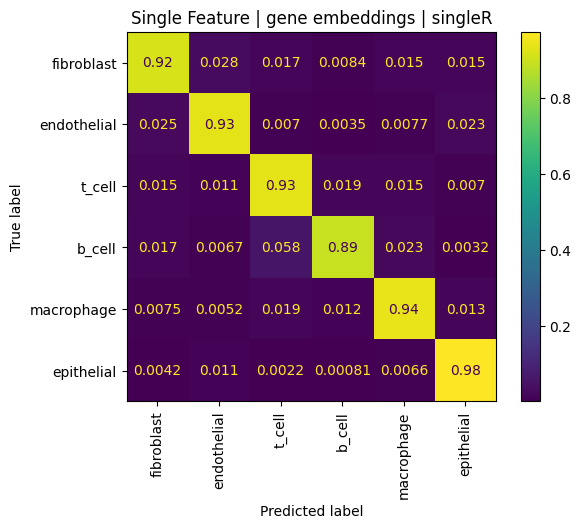

Classification Report:
              precision    recall  f1-score   support

  fibroblast       0.93      0.92      0.92      5586
 endothelial       0.93      0.93      0.93      5972
      t_cell       0.94      0.93      0.94      7248
      b_cell       0.92      0.89      0.90      3132
  macrophage       0.90      0.94      0.92      3624
  epithelial       0.97      0.98      0.97     11134

    accuracy                           0.94     36696
   macro avg       0.93      0.93      0.93     36696
weighted avg       0.94      0.94      0.94     36696



In [12]:
# Evaluation for Transformer using a single feature (e.g., gene embeddings only)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features, lbls in test_loader:
        features = features.to(device)
        lbls = lbls.to(device)
        
        outputs = model(features)  # Only one input here
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbls.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)

disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title(f"Single Feature | {train_on} embeddings | {label_source}")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_classes))

In [13]:
report_dict = classification_report(all_labels, all_preds, target_names=target_classes, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

save_path = os.path.join(results_dir, "T1")
os.makedirs(save_path, exist_ok=True)

if not use_projections:
    report_df.to_csv(os.path.join(save_path, f"classification_report_{label_source}_{morph_version}.csv"))
else:
    report_df.to_csv(os.path.join(save_path, f"classification_report_{label_source}_{morph_version}_proj.csv"))

# Version 2: Transformer Using One Feature Set Plus Spatial Encoding

In [ ]:

train_on = "gene" # gene or morphology

if train_on == "gene":
    train_embeddings = gene_embeddings.copy()
    if use_projections:
        input_dim = 128
    else:
        input_dim = 512
else:
    train_embeddings = morph_embeddings.copy()
    if use_projections:
        input_dim = 128
    else:
        input_dim = 1536
    
num_epochs = 20 
batch_size = 64


In [ ]:
# Assume gene_embeddings (DataFrame with shape [N, 512]), spatial_coords (DataFrame with shape [N, 2]), and labels are already loaded.

# Positional Encoding for 2D coordinates (as in the original code)
class PositionalEncoding2D(nn.Module):
    """Sinusoidal positional encoding for spatial coordinates."""
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.proj = nn.Linear(4, d_model)  # Projects 4-dim (sin and cos for x and y) to d_model
        
    def forward(self, coords):
        # coords shape: [B, 2]
        x = coords[:, 0] * 2 * torch.pi
        y = coords[:, 1] * 2 * torch.pi
        pe = torch.stack([
            torch.sin(x), torch.cos(x),
            torch.sin(y), torch.cos(y)
        ], dim=-1)  # Shape: [B, 4]
        pe = self.proj(pe)  # Shape: [B, d_model]
        return pe

# Relative Position Transformer Layer (adapted from the original)
class RelativePositionTransformerLayer(nn.TransformerEncoderLayer):
    """Enhanced transformer layer with additional positional attention."""
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.pos_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.pos_norm = nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)
    
    def forward(self, src, pos_emb):
        # pos_emb: [B, 1, d_model] provided externally
        pos_emb = pos_emb.expand(-1, src.shape[1], -1)  # Expand to [B, seq_len, d_model]
        src2 = self.self_attn(src, src, src, need_weights=False)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.pos_attn(src, pos_emb, pos_emb)[0]
        src = src + self.dropout2(src2)
        src = self.pos_norm(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout3(src2)
        src = self.norm2(src)
        return src

# Dataset that returns a single feature, spatial coordinates, and label.
class SingleFeatureSpatialDataset(Dataset):
    def __init__(self, features, spatial, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.spatial = torch.tensor(spatial.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.spatial[idx], self.labels[idx]

# Transformer model that uses one feature set plus spatial encoding.
class SingleFeatureSpatialTransformer(nn.Module):
    def __init__(self, input_dim, d_model=512, num_heads=8, num_classes=3, num_layers=6):
        super().__init__()
        self.feature_proj = nn.Linear(input_dim, d_model)
        self.spatial_pe = PositionalEncoding2D(d_model)
        # Use the modified transformer layers with relative positional attention.
        self.layers = nn.ModuleList([
            RelativePositionTransformerLayer(d_model, num_heads)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )
    
    def forward(self, feature, spatial):
        # feature: [B, input_dim]
        # spatial: [B, 2]
        feature_emb = self.feature_proj(feature)  # [B, d_model]
        spatial_emb = self.spatial_pe(spatial)      # [B, d_model]
        # Stack the feature token and the spatial token into a sequence.
        tokens = torch.stack([feature_emb, spatial_emb], dim=1)  # [B, 2, d_model]
        # Prepare a positional token for the attention layers (unsqueezed spatial embedding)
        pos_token = spatial_emb.unsqueeze(1)  # [B, 1, d_model]
        for layer in self.layers:
            tokens = layer(tokens, pos_token)
        pooled = tokens.mean(dim=1)
        return self.classifier(pooled)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(np.unique(labels))  # or set explicitly if known

# Initialize dataset and model (using gene embeddings and spatial_coords)
dataset = SingleFeatureSpatialDataset(train_embeddings, spatial_coords, labels)
all_indices = np.arange(len(dataset))
train_idx, test_idx = train_test_split(
    all_indices, test_size=0.2, random_state=42, stratify=labels
)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = SingleFeatureSpatialTransformer(input_dim=input_dim, d_model=512, num_heads=8, num_classes=num_classes).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for features, spatial, lbls in progress_bar:
        features, spatial, lbls = features.to(device), spatial.to(device), lbls.to(device)
        optimizer.zero_grad()
        outputs = model(features, spatial)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * features.size(0)
        _, predicted = torch.max(outputs, 1)
        total += lbls.size(0)
        correct += (predicted == lbls).sum().item()
        progress_bar.set_postfix(loss=loss.item())
    avg_loss = epoch_loss / total
    accuracy = correct / total * 100 
    print(f"Epoch {epoch+1}: Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")
    
    # Evaluation on test set
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for features, spatial, lbls in test_loader:
            features, spatial, lbls = features.to(device), spatial.to(device), lbls.to(device)
            outputs = model(features, spatial)
            loss = criterion(outputs, lbls)
            test_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += lbls.size(0)
            test_correct += (predicted == lbls).sum().item()
    avg_test_loss = test_loss / test_total
    test_accuracy = test_correct / test_total * 100
    print(f"Test: Loss: {avg_test_loss:.4f} | Accuracy: {test_accuracy:.2f}%")


In [ ]:
# Evaluation for Transformer using a single feature with spatial encoding
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features, spatial, lbls in test_loader:
        features = features.to(device)
        spatial = spatial.to(device)
        lbls = lbls.to(device)
        
        outputs = model(features, spatial)  # Pass both feature and spatial inputs
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbls.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)

disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix (Feature + Spatial)")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_classes))

In [ ]:
report_dict = classification_report(all_labels, all_preds, target_names=target_classes, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

save_path = os.path.join(results_dir, "T2")
os.makedirs(save_path, exist_ok=True)

if not use_projections:
    report_df.to_csv(os.path.join(save_path, f"classification_report_{label_source}_{morph_version}.csv"))
else:
    report_df.to_csv(os.path.join(save_path, f"classification_report_{label_source}_{morph_version}_proj.csv"))

# Version 3: Transformer Using Both Feature Sets without Spatial Encoding

In [ ]:
# Assume gene_embeddings (DataFrame with shape [N, 512]),
# morph_embeddings (DataFrame with shape [N, 1536]),
# and labels (a Pandas Series with mapped integer labels)
# are already loaded.

# Dataset that returns both gene and morphology features along with labels.
class DualFeatureDataset(Dataset):
    def __init__(self, gene, morph, labels):
        self.gene = torch.tensor(gene.values, dtype=torch.float32)  # [N, 512]
        self.morph = torch.tensor(morph.values, dtype=torch.float32)  # [N, 1536]
        self.labels = torch.tensor(labels.values, dtype=torch.long)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.gene[idx], self.morph[idx], self.labels[idx]

# Transformer model that processes both feature sets without spatial encoding.
class DualFeatureTransformer(nn.Module):
    def __init__(self, d_model=512, num_heads=8, num_classes=3, num_layers=6):
        super().__init__()
        # Projections for each modality
        gene_input_dim = 128 if use_projections else 512
        self.gene_proj = nn.Linear(gene_input_dim, d_model)

        morph_input_dim = 128 if use_projections else 1536
        self.morph_proj = nn.Linear(morph_input_dim, d_model)
        # Modality type tokens
        self.gene_type = nn.Parameter(torch.randn(1, d_model))
        self.morph_type = nn.Parameter(torch.randn(1, d_model))
        # Standard Transformer Encoder layers (no spatial information)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, batch_first=True)
            for _ in range(num_layers)
        ])
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )
        
    def forward(self, gene, morph):
        # Project and add modality type tokens
        gene_emb = self.gene_proj(gene) + self.gene_type   # [B, d_model]
        morph_emb = self.morph_proj(morph) + self.morph_type # [B, d_model]
        # Stack the embeddings to form a sequence of two tokens
        tokens = torch.stack([gene_emb, morph_emb], dim=1)   # [B, 2, d_model]
        # Process tokens with standard transformer encoder layers
        for layer in self.layers:
            tokens = layer(tokens)
        # Pool tokens (here simple mean pooling) and classify
        pooled = tokens.mean(dim=1)  # [B, d_model]
        return self.classifier(pooled)

# Hyperparameters and dataset preparation
num_epochs = 20 
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(np.unique(labels))  # Alternatively, set this explicitly if known

# Create dataset and perform a stratified 80/20 train-test split
dataset = DualFeatureDataset(gene_embeddings, morph_embeddings, labels)
all_indices = np.arange(len(dataset))
train_idx, test_idx = train_test_split(all_indices, test_size=0.2, random_state=42, stratify=labels)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
model = DualFeatureTransformer(d_model=512, num_heads=8, num_classes=num_classes, num_layers=6).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for gene, morph, lbls in progress_bar:
        gene, morph, lbls = gene.to(device), morph.to(device), lbls.to(device)
        optimizer.zero_grad()
        outputs = model(gene, morph)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * gene.size(0)
        _, predicted = torch.max(outputs, dim=1)
        total += lbls.size(0)
        correct += (predicted == lbls).sum().item()
        progress_bar.set_postfix(loss=loss.item())
        
    avg_loss = epoch_loss / total
    accuracy = correct / total * 100 
    print(f"Epoch {epoch+1}: Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")
    
    # Evaluation on the test set
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for gene, morph, lbls in test_loader:
            gene, morph, lbls = gene.to(device), morph.to(device), lbls.to(device)
            outputs = model(gene, morph)
            loss = criterion(outputs, lbls)
            test_loss += loss.item() * gene.size(0)
            _, predicted = torch.max(outputs, dim=1)
            test_total += lbls.size(0)
            test_correct += (predicted == lbls).sum().item()
    avg_test_loss = test_loss / test_total
    test_accuracy = test_correct / test_total * 100
    print(f"Test: Loss: {avg_test_loss:.4f} | Accuracy: {test_accuracy:.2f}%")

In [ ]:
# Evaluation for DualFeatureTransformer using both gene and morphology features (no spatial encoding)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for gene, morph, lbls in test_loader:
        gene = gene.to(device)
        morph = morph.to(device)
        lbls = lbls.to(device)

        outputs = model(gene, morph)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbls.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)

disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix (Dual Feature Transformer)")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_classes))

In [ ]:
report_dict = classification_report(all_labels, all_preds, target_names=target_classes, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

save_path = os.path.join(results_dir, "T3")
os.makedirs(save_path, exist_ok=True)

if not use_projections:
    report_df.to_csv(os.path.join(save_path, f"classification_report_{label_source}_{morph_version}.csv"))
else:
    report_df.to_csv(os.path.join(save_path, f"classification_report_{label_source}_{morph_version}_proj.csv"))

In [15]:
# split_save_dir = "/rsrch5/home/plm/phacosta/xenium_project/Code/data_files"

# with open(f"{split_save_dir}/train_test_indices.pkl", "wb") as f:
#     pickle.dump({"train_idx": train_idx, "test_idx": test_idx}, f)